In [200]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss

In [201]:
df = pd.read_csv('df.csv')

/Users/kasey.larsen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [202]:
df.head()

,fullVisitorId,channelGrouping,date,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,deviceCategory,...,sessionQualityDim,timeOnSite,transactions,transactionRevenue,totalTransactionRevenue,source,weekday,day,month,year
0,461840188517261,Organic Search,2018-04-11,1523458419,1,1.523458e+09,Chrome,Windows,0.0,desktop,...,1,0,0,0,0,google,2,11,4,2018
1,650183049109374,Organic Search,2017-06-01,1496340796,1,1.496341e+09,Chrome,Android,1.0,mobile,...,0,211,0,0,0,google,3,1,6,2017
2,679030251760221,Organic Search,2016-09-18,1474198386,3,1.474198e+09,Edge,Windows,0.0,desktop,...,0,0,0,0,0,google,6,18,9,2016
3,750929315523353,Organic Search,2017-02-03,1486157741,1,1.486158e+09,Safari,Macintosh,0.0,desktop,...,0,0,0,0,0,(direct),4,3,2,2017
4,3237279499166974,Referral,2018-03-03,1520086654,1,1.520087e+09,Chrome,Macintosh,0.0,desktop,...,1,79,0,0,0,Other,5,3,3,2018


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82707 entries, 0 to 82706
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   fullVisitorId            82707 non-null  object 
 1   channelGrouping          82707 non-null  object 
 2   date                     82707 non-null  object 
 3   visitId                  82707 non-null  int64  
 4   visitNumber              82707 non-null  int64  
 5   visitStartTime           82707 non-null  float64
 6   browser                  82707 non-null  object 
 7   operatingSystem          82707 non-null  object 
 8   isMobile                 82707 non-null  float64
 9   deviceCategory           82707 non-null  object 
 10  continent                82707 non-null  object 
 11  subContinent             82707 non-null  object 
 12  country                  82707 non-null  object 
 13  hits_y                   82707 non-null  int64  
 14  pageviews             

In [204]:
# Correct dtpes
df['pageviews'] = df['pageviews'].astype(int)
df['newVisits'] = df['newVisits'].astype(int)
df['bounces'] = df['bounces'].astype(int)
df['hits_y'] = df['hits_y'].astype(int)
df['sessionQualityDim'] = df['sessionQualityDim'].astype(int)
df['timeOnSite'] = df['timeOnSite'].astype(int)
df['transactions'] = df['transactions'].astype(int)
df['transactionRevenue'] = df['transactionRevenue'].astype(int)
df['totalTransactionRevenue'] = df['totalTransactionRevenue'].astype(int)
df['fullVisitorId'] = df['fullVisitorId'].astype(str)
df['visitId'] = df['visitId'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82707 entries, 0 to 82706
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fullVisitorId            82707 non-null  object        
 1   channelGrouping          82707 non-null  object        
 2   date                     82707 non-null  datetime64[ns]
 3   visitId                  82707 non-null  object        
 4   visitNumber              82707 non-null  int64         
 5   visitStartTime           82707 non-null  float64       
 6   browser                  82707 non-null  object        
 7   operatingSystem          82707 non-null  object        
 8   isMobile                 82707 non-null  float64       
 9   deviceCategory           82707 non-null  object        
 10  continent                82707 non-null  object        
 11  subContinent             82707 non-null  object        
 12  country                  82707 n

In [206]:
df = df.drop(['continent', 'country', 'date', 'transactionRevenue'], axis=1)

### Creating Dummy Regressors

In [207]:
#Get dummies for catergorical data
df = pd.get_dummies(df, columns=['channelGrouping'], prefix=['channel'])
df = pd.get_dummies(df, columns=['browser'], prefix=['browser'])
df = pd.get_dummies(df, columns=['operatingSystem'], prefix=['operatingSystem'])
df = pd.get_dummies(df, columns=['deviceCategory'], prefix=['deviceCategory'])
df = pd.get_dummies(df, columns=['subContinent'], prefix=['subContinent'])
df = pd.get_dummies(df, columns=['source'], prefix=['source'])

In [208]:
df.head()

,fullVisitorId,visitId,visitNumber,visitStartTime,isMobile,hits_y,pageviews,bounces,newVisits,sessionQualityDim,...,source_Partners,source_analytics.google.com,source_baidu,source_dfa,source_google,source_google.com,source_m.facebook.com,source_reddit.com,source_sites.google.com,source_youtube.com
0,461840188517261,1523458419,1,1.523458e+09,0.0,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
1,650183049109374,1496340796,1,1.496341e+09,1.0,11,10,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,679030251760221,1474198386,3,1.474198e+09,0.0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,750929315523353,1486157741,1,1.486158e+09,0.0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,3237279499166974,1520086654,1,1.520087e+09,0.0,10,6,0,1,1,...,0,0,0,0,0,0,0,0,0,0


### Spliting data to Train/Test

In [209]:
len(df) * .7, len(df) * .3

(57894.899999999994, 24812.1)

In [210]:
#Get train/test data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='totalTransactionRevenue'), 
                                                    df.totalTransactionRevenue, test_size=0.3, 
                                                    random_state=47)

In [211]:
#checking shape
X_train.shape, X_test.shape

((57894, 77), (24813, 77))

In [212]:
#checking shape
y_train.shape, y_test.shape

((57894,), (24813,))

In [213]:
#Save the 'fullVisitorId', 'visitId' columns from the train/test data into names_train and names_test
#Then drop those columns from `X_train` and `X_test`
names_list = ['fullVisitorId', 'visitId']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((57894, 75), (24813, 75))

In [214]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57894 entries, 59440 to 51078
Data columns (total 75 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   visitNumber                    57894 non-null  int64  
 1   visitStartTime                 57894 non-null  float64
 2   isMobile                       57894 non-null  float64
 3   hits_y                         57894 non-null  int64  
 4   pageviews                      57894 non-null  int64  
 5   bounces                        57894 non-null  int64  
 6   newVisits                      57894 non-null  int64  
 7   sessionQualityDim              57894 non-null  int64  
 8   timeOnSite                     57894 non-null  int64  
 9   transactions                   57894 non-null  int64  
 10  weekday                        57894 non-null  int64  
 11  day                            57894 non-null  int64  
 12  month                          57894 non-n

In [215]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24813 entries, 30405 to 38495
Data columns (total 75 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   visitNumber                    24813 non-null  int64  
 1   visitStartTime                 24813 non-null  float64
 2   isMobile                       24813 non-null  float64
 3   hits_y                         24813 non-null  int64  
 4   pageviews                      24813 non-null  int64  
 5   bounces                        24813 non-null  int64  
 6   newVisits                      24813 non-null  int64  
 7   sessionQualityDim              24813 non-null  int64  
 8   timeOnSite                     24813 non-null  int64  
 9   transactions                   24813 non-null  int64  
 10  weekday                        24813 non-null  int64  
 11  day                            24813 non-null  int64  
 12  month                          24813 non-n

### Dummy Regressor

In [216]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

1919598.7494386293

In [217]:
#Fit the dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[1919598.75]])

### R-Squared

In [218]:
y_tr_pred_ = train_mean * np.ones(len(y_train))
y_tr_pred_[:5]

array([1919598.75, 1919598.75, 1919598.75, 1919598.75, 1919598.75])

In [219]:
y_tr_pred = dumb_reg.predict(X_train)
y_te_pred = train_mean * np.ones(len(y_test))

In [220]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00014508860797213252)

### Mean Absolute Error

In [221]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(3796424.80418047, 3441745.9292575517)

### Mean Squared Error

In [222]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(1.6122377656468358e+16, 842704989041355.8)

### Scaling Data

In [223]:
#Call the StandardScaler`s fit method
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### LinearRegression

In [224]:
lm = LinearRegression().fit(X_train_scaled, y_train)

In [225]:
y_train_pred = lm.predict(X_train_scaled)
y_test_pred = lm.predict(X_test_scaled)

In [226]:
median_r2 = r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)
median_r2

(0.38291465424265514, -3.5376161570781006)

In [227]:
median_mae = mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)
median_mae

(27358147.058286894, 27380983.043233044)

In [228]:
median_mse = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
median_mse

(1.6122377656468358e+16, 842704989041355.8)

### Pipeline

In [229]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [230]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f80d5ee73a0>)),
                ('linearregression', LinearRegression())])

In [231]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [232]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.36216362816800907, -3.451261364539058)

In [233]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(29796485.828166027, 29815715.842431497)

### New pipeline

In [234]:
pipe30 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=30),
    LinearRegression()
)

In [235]:
pipe30.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=30,
                             score_func=<function f_regression at 0x7f80d5ee73a0>)),
                ('linearregression', LinearRegression())])

In [236]:
y_train_pred = pipe30.predict(X_train)
y_test_pred = pipe30.predict(X_test)

In [237]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.3663147787239911, -3.4663825188697146)

In [238]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(29879146.57524418, 29936323.27797937)

### Cross Validation

In [239]:
cv_results = cross_validate(pipe15, X_train, y_train, cv=5)

In [240]:
cv_scores = cv_results['test_score']
cv_scores

array([-8.71, -2.7 ,  0.04, -4.14, -7.95])

In [241]:
np.mean(cv_scores), np.std(cv_scores)

(-4.691906491044728, 3.270373926147989)

In [242]:
np.round((np.mean(cv_scores) - 2 * np.std(cv_scores), np.mean(cv_scores) + 2 * np.std(cv_scores)), 2)

array([-11.23,   1.85])

### Hyperparameter search using GridSearchCV

In [243]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [244]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [246]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [247]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f80d5ee73a0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [248]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 1}

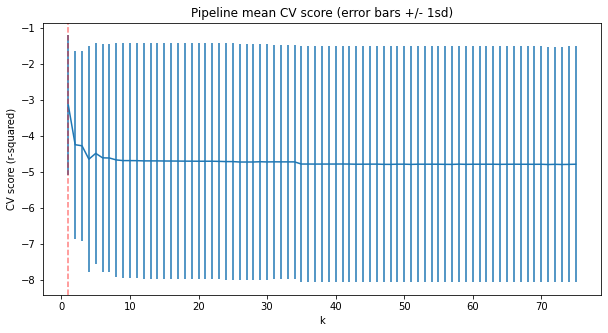

In [249]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [250]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [251]:
pd.options.display.max_rows = 4000

In [252]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

pageviews    5.676820e+07
dtype: float64

### Random Forest

In [253]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [254]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [255]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([-0.41, -0.14,  0.07, -0.01, -0.14])

In [256]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(-0.12525145585531194, 0.1647957074019922)

### Random Forest Hyperparameter search using GridSearchCV

In [257]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [258]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [259]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [260]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

In [261]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([-0.4 ,  0.03,  0.08,  0.01, -0.09])

In [262]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(-0.07463892418771205, 0.17318224026047627)

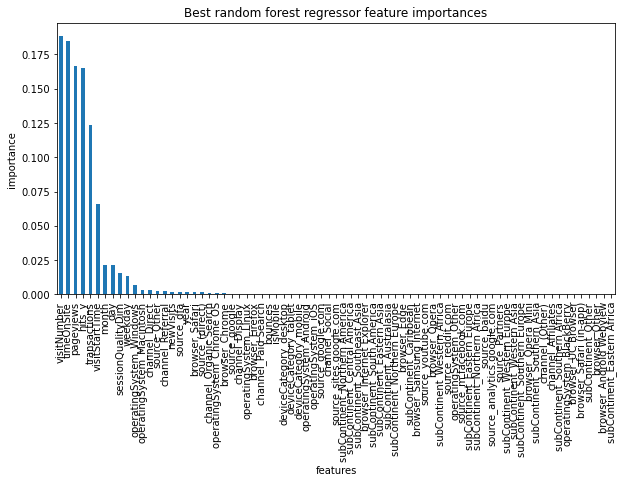

In [264]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [265]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.988
Random Forest: f1-score=0.984
